# 🎮 Video Game Sales Analysis - 20 Questions

## **Level 1: Basic Exploration and Pandas**

1. **How many unique platforms and genres are present in the dataset?**  
   Count the unique values in the `Platform` and `Genre` columns.

2. **What are the top 5 most common publishers and genres by game count?**  
   Use `value_counts()` to get the top 5 publishers and genres.

3. **Find the average and median global sales across all platforms.**  
   Group the data by platform and calculate the mean and median for `Global_Sales`.

4. **Which year had the highest number of game releases, and how many games were released that year?**  
   Use `groupby()` and `count()` to find the year with the most releases.

5. **Plot a bar chart of total global sales by genre.**  
   Group by `Genre` and aggregate global sales, then plot.

---

## **Level 2: Intermediate Analysis**

6. **What are the top 10 games by global sales?**  
   Sort the dataset by Global_Sales and select the top 10.

7. **What is the average sales per year globally across all platforms?**  
    Group the data by year and compute the mean global sales.

8. **Create a scatter plot of NA_Sales vs. EU_Sales. What pattern, if any, can you observe?**  
   Use a scatter plot to identify relationships or trends.
   
9. **Find the platform with the highest total sales globally. Which game contributed the most to these sales?**  
   Group by `Platform`, aggregate `Global_Sales`, and identify the top game contributing to the platform’s success.

9. **Compute the correlation between global sales and regional sales (NA, EU, JP, etc.).**  
   Use the `corr()` method to analyze correlations.

---

## **Level 3: Data Science Applications**

11. **Perform linear regression to predict Global_Sales using NA_Sales and EU_Sales as predictors.**  
    Train a regression model using `sklearn` or `statsmodels`.

12. **Perform feature scaling on the sales columns and train a k-means clustering model to group games into clusters based on regional sales.**   
    Apply scaling and clustering to see patterns in the data.

13. **Which cluster has the games with the highest sales, and what is the general genre distribution within that cluster?**   
    Analyze the clusters and their characteristics.

14. **Compute the rolling average of yearly sales and identify any trends or spikes.**   
   Use the `rolling()` method to smooth out time series data.

15. **Use the merge_asof() method to combine the yearly sales data with an external time series dataset (like inflation rates) and analyze any relationships.**   
    Integrate and interpret data from two time series.

---

## **Level 4: Advanced Analytics & Visualization**

16. **Generate a heatmap showing the correlation between platforms, genres, and regional sales.**   
    Visualize the correlations to uncover hidden patterns.

17. **Identify genres with the highest variance in sales across regions using standard deviation.**
    Find which genres have the most sales variability.

18. **Train both a classification model and a regression model to predict global sales.**  
    Using `scikit-learn` or `statsmodels` to compare the performance of each and discuss when each model would be appropriate.

20. **Build a predictive model to classify whether a game will have high or low global sales based on its regional sales.**
    Train a classification model using `scikit-learn` or `statsmodels`.

21. **Analyze outliers in the dataset using the IQR (interquartile range) method and visualize the top 10 outliers.**   
    Detect and visualize outliers in the dataset.



# Imports Helper Functions Data cleaning

In [ ]:
# Import section
from typing import Tuple

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Helper functions


def freedman_diaconis_bins(data: np.ndarray) -> int:
    """Calculate the optimal number of bins for a histogram using the Freedman-Diaconis rule.

    The Freedman-Diaconis rule is robust to outliers and works well for skewed data.
    It calculates the bin width using the interquartile range (IQR) and adjusts the
    number of bins accordingly.

    Args:
        data (array-like): Input data, typically a 1D array of numerical values.

    Returns:
        int: Optimal number of bins for the histogram. If the bin width is very small,
        a minimum of 1 bin is enforced.

    Example:
        >>> data = np.random.randn(1000)
        >>> freedman_diaconis_bins(data)
        16
    """
    # Ensure input is a NumPy array
    data = np.asarray(data)

    # Calculate the interquartile range (IQR)
    iqr = np.subtract(*np.percentile(data, [75, 25]))

    # Compute the bin width using the Freedman-Diaconis rule
    bin_width = 2 * iqr / np.cbrt(len(data))

    # If bin_width is too small, return at least 1 bin
    if bin_width <= 0:
        return 1

    # Calculate the number of bins and return it
    return max(1, int(np.ceil((data.max() - data.min()) / bin_width)))


def optimal_figsize(
    data: np.ndarray,
    bins: int = None,
    base_width: float = 8.0,
    base_height: float = 5.0,
) -> Tuple[float, float]:
    """Determine the optimal figure size based on the number of bins.

    Dynamically adjusts the width of the plot based on the number of bins (if
    specified) or calculates the optimal number using the Freedman-Diaconis rule.
    The height is kept fixed or adjusted based on user input. Recommended for
    small datasets.

    Args:
        data (np.ndarray): The input data array to be visualized.
        bins (int, optional): The number of bins for the histogram. If not provided,
            it is calculated using the Freedman-Diaconis rule.
        base_width (float, optional): The base width of the figure. Defaults to 8.0.
        base_height (float, optional): The base height of the figure. Defaults to 5.0.

    Returns:
        Tuple[float, float]: The optimal width and height of the figure.
    """
    # Calculate bins if not provided
    if bins is None:
        bins = freedman_diaconis_bins(data)

    # Adjust width based on the number of bins
    width = base_width + bins * 0.1
    return (width, base_height)


def optimal_figsize_by_range(
    data: np.ndarray,
    base_width: float = 8.0,
    base_height: float = 5.0,
    scale_factor: float = 0.5,
) -> Tuple[float, float]:
    """Determine the optimal figure size based on the data range.

    Adjusts the width of the figure proportionally to the range of the data to
    ensure adequate spacing and visibility. The height remains fixed unless
    adjusted by user input. Recommended for small datasets

    Args:
        data (np.ndarray): The input data array to be visualized.
        base_width (float, optional): The base width of the figure. Defaults to 8.0.
        base_height (float, optional): The base height of the figure. Defaults to 5.0.
        scale_factor (float, optional): Scaling factor to adjust the width based
            on the data range. Defaults to 0.5.

    Returns:
        Tuple[float, float]: The optimal width and height of the figure.
    """
    # Calculate the range of the data
    data_range = np.max(data) - np.min(data)

    # Adjust width based on data range
    width = base_width + data_range * scale_factor
    return (width, base_height)


def figsize_by_samples(
    n_samples: int, base_width: float = 8.0, base_height: float = 5.0
) -> Tuple[float, float]:
    """Determine the optimal figure size based on the number of samples.

    Adjusts the width of the figure proportionally to the number of samples,
    ensuring adequate space for larger datasets. The height remains fixed
    unless specified. Recommended for large datasets.

    Args:
        n_samples (int): The number of samples to be visualized.
        base_width (float, optional): The base width of the figure. Defaults to 8.0.
        base_height (float, optional): The base height of the figure. Defaults to 5.0.

    Returns:
        Tuple[float, float]: The optimal width and height of the figure.
    """
    # Adjust width based on the number of samples
    width = base_width + (n_samples // 1000)
    return (width, base_height)

In [39]:
# Load the data
df_raw = pd.read_csv("vgsales_new.csv")

# Checking the dataset
df_raw.head(10)
df_raw.shape

# Checks for potential data cleaning
df_raw.isnull().sum()
df_raw.nunique()
df_raw.duplicated().sum()

# Copy the dataset for cleaning
df = df_raw.copy()

# Drop Null Values
df = df.dropna()
# df.shape
# df.head(10)

# Data check
# df.info()
# df.describe()

# Convert Year to datetime
df["Year"] = df["Year"].astype(int)
df["Year"] = pd.to_datetime(df["Year"], format="%Y")
df = df[(df["Year"].dt.year >= 1980) & (df["Year"].dt.year <= 2020)]
# df.info()
df.head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,259,Asteroids,2600,1980-01-01,Shooter,Atari,4.00,0.26,0.0,0.05,4.31
1,545,Missile Command,2600,1980-01-01,Shooter,Atari,2.56,0.17,0.0,0.03,2.76
2,1768,Kaboom!,2600,1980-01-01,Misc,Activision,1.07,0.07,0.0,0.01,1.15
3,1971,Defender,2600,1980-01-01,Misc,Atari,0.99,0.05,0.0,0.01,1.05
4,2671,Boxing,2600,1980-01-01,Fighting,Activision,0.72,0.04,0.0,0.01,0.77
5,4027,Ice Hockey,2600,1980-01-01,Sports,Activision,0.46,0.03,0.0,0.01,0.49
6,5368,Freeway,2600,1980-01-01,Action,Activision,0.32,0.02,0.0,0.00,0.34
7,6319,Bridge,2600,1980-01-01,Misc,Activision,0.25,0.02,0.0,0.00,0.27
8,6898,Checkers,2600,1980-01-01,Misc,Atari,0.22,0.01,0.0,0.00,0.24
9,240,Pitfall!,2600,1981-01-01,Platform,Activision,4.21,0.24,0.0,0.05,4.50


# Level 1: Basic Exploration and Pandas

In [40]:
# 1. How many unique platforms and genres are present in the dataset?
unique_platforms = df["Platform"].nunique()
print("Number of unique platforms:", unique_platforms)
unique_genres = df["Genre"].nunique()
print("Number of unique genres:", unique_genres)

Number of unique platforms: 31
Number of unique genres: 12


In [41]:
# 2. What are the top 5 most common publishers and genres by game count?
common_publishers = df["Publisher"].value_counts().head(5)
common_genres = df["Genre"].value_counts().head(5)
print(f"Most common publisher is: {common_publishers}")
print(f"Most common Genre is: {common_genres}")

# print("Genre with the highest number of games: ", highest_genre)
# print(df['Genre'].value_counts().head(5))

Most common publisher is: Publisher
Electronic Arts                 1339
Activision                       966
Namco Bandai Games               928
Ubisoft                          918
Konami Digital Entertainment     823
Name: count, dtype: int64
Most common Genre is: Genre
Action          3251
Sports          2304
Misc            1686
Role-Playing    1470
Shooter         1282
Name: count, dtype: int64


In [42]:
# 3. Find the average and median global sales across all platforms.
platform = df.groupby(by=["Platform"])
avg_mean_global_sales = platform["Global_Sales"].agg(
    ["mean", "median", "std", "count"]
)
print(avg_mean_global_sales)

              mean  median       std  count
Platform                                   
2600      0.746293   0.475  0.955571    116
3DO       0.033333   0.020  0.023094      3
3DS       0.493527   0.130  1.403221    499
DC        0.307115   0.135  0.469912     52
DS        0.384284   0.110  1.444833   2131
GB        2.622887   1.180  5.390733     97
GBA       0.388830   0.160  0.912071    786
GC        0.363727   0.150  0.693107    542
GEN       1.050370   0.150  1.492217     27
GG        0.040000   0.040       NaN      1
N64       0.690538   0.270  1.321415    316
NES       2.561939   1.375  5.108195     98
NG        0.120000   0.100  0.082241     12
PC        0.271535   0.040  0.687425    938
PCFX      0.030000   0.030       NaN      1
PS        0.611766   0.260  1.056998   1189
PS2       0.579906   0.230  1.138558   2127
PS3       0.728029   0.290  1.424341   1304
PS4       0.827679   0.220  1.618966    336
PSP       0.243701   0.090  0.524226   1197
PSV       0.150244   0.060  0.25

In [43]:
# 4.Which year had the highest number of game releases, and how many games were released that year?
# Use `groupby()` and `count()` to find the year with the most releases.

# my code
# highest_year_of_releases = df.groupby('Year')['Year'].count().idxmax()
# games_released_2009 = df[df['Year']== 2009]['Name'].count()

# Optimize code
highest_releases = df["Year"].dt.year.value_counts().idxmax()
print(f"The year with highest release was: {highest_releases}")
games_released = df["Year"].value_counts().max()
print(f"{games_released} games where released in 2009")

The year with highest release was: 2009
1431 games where released in 2009


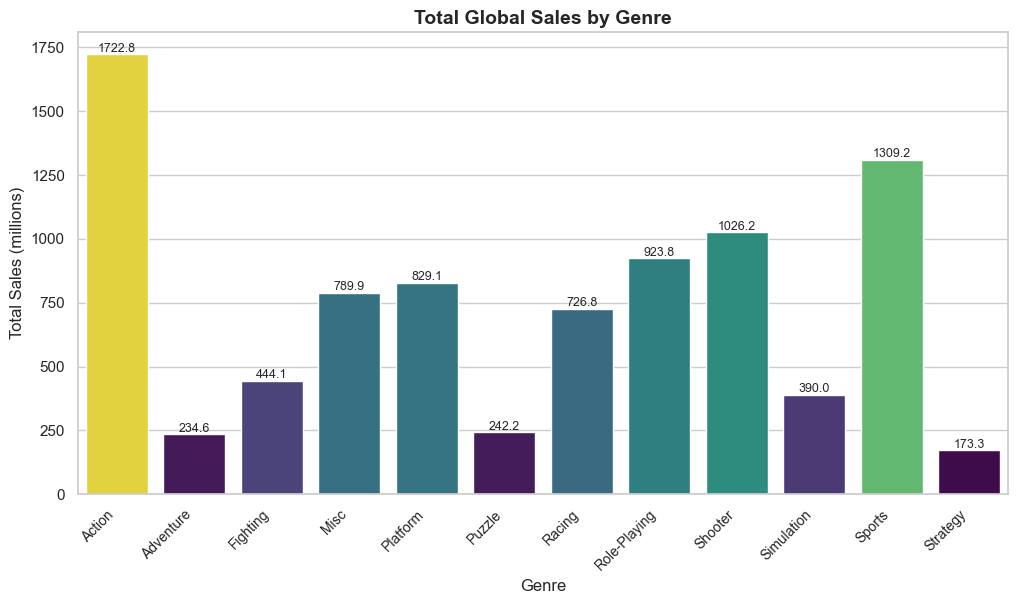

In [44]:
# 5. Plot a bar chart of total global sales by genre.
# Group by `Genre` and aggregate global sales, then plot.

total_sales = df.groupby("Genre")["Global_Sales"].sum()

# Plot setup
plt.figure(figsize=(12, 6))

# Create the barplot
sns.barplot(
    x=total_sales.index,
    y=total_sales.values,
    hue=total_sales.values,
    palette="viridis",
    legend=False,
)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha="right", fontsize=10)

# Title and axis labels
plt.title("Total Global Sales by Genre", fontsize=14, fontweight="bold")
plt.xlabel("Genre", size=12)
plt.ylabel("Total Sales (millions)", fontsize=12)

# Add values on top of bars for clarity
for i, value in enumerate(total_sales.values):
    plt.text(i, value + 10, f"{value:.1f}", ha="center", fontsize=9)

    # Show the plot
plt.show()


# My code
# figsize = optimal_figsize(total_sales, base_width=10, base_height=6)  # Calculating the optimal figure size

# # Convert width and height for seaborn
# height = figsize[1]  # Height stays the same
# aspect = figsize[0] / height  # Aspect ratio to control width
# sns.set_theme(style="whitegrid", palette="deep")


# _ = sns.barplot(x=total_sales.index, y=total_sales.values)
# plt.title("Total global sales by genre")
# plt.show()

# Level 2: Intermediate Analysis

In [45]:
# 6. What are the top 10 games by global sales?
# Sort the dataset by Global_Sales and select the top 10.

# top_10_games = df.sort_values(by='Global_Sales', ascending=False).head(10)

sorted_df = df.sort_values(by=["Name", "Global_Sales"])
top_10_games = (
    sorted_df[["Name", "Global_Sales"]]
    .sort_values(by="Global_Sales", ascending=False)
    .head(10)
)
print(top_10_games)

                           Name  Global_Sales
6113                 Wii Sports         82.74
122           Super Mario Bros.         40.24
8323             Mario Kart Wii         35.82
9751          Wii Sports Resort         33.00
705    Pokemon Red/Pokemon Blue         31.37
188                      Tetris         30.26
6114      New Super Mario Bros.         30.01
6115                   Wii Play         29.02
9752  New Super Mario Bros. Wii         28.62
108                   Duck Hunt         28.31


Average sales per year (highest to lowest):
Year
1989    4.320588
1985    3.852857
1984    3.597143
1988    3.148000
1990    3.086875
1992    1.771163
1986    1.765238
1987    1.358750
1980    1.264444
1983    0.987647
1982    0.801667
1991    0.786098
1981    0.777609
1993    0.766333
1996    0.757224
1999    0.743402
1997    0.695433
2001    0.687697
1998    0.676702
2013    0.674194
1994    0.654298
2014    0.581086
2000    0.577536
2004    0.556465
2012    0.554947
2006    0.516905
2007    0.507843
2005    0.489861
2010    0.477558
2002    0.477105
2008    0.475420
2009    0.466317
2003    0.461742
2011    0.454049
2015    0.430684
1995    0.402329
2020    0.290000
2016    0.207310
2017    0.016667
Name: Global_Sales, dtype: float64


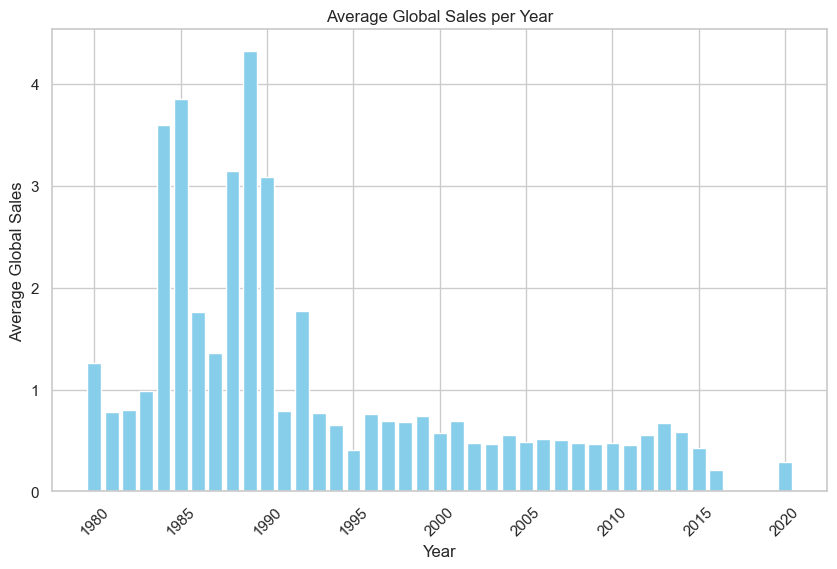

In [46]:
# 7. What is the average sales per year globally across all platforms?
# Group the data by year and compute the mean global sales.

## My code
grouped_by_year = df.groupby(df["Year"].dt.year)
# avg_sales_per_year = grouped_by_year['Global_Sales'].mean()
# print(f"Average sales per year Globally:\n {avg_sales_per_year}")

## Refactor
# To display by year
# avg_sales_per_year = grouped_by_year['Global_Sales'].mean()
# avg_sales_per_year = avg_sales_per_year.sort_index()  # Sort by year
# print("Average sales per year (chronological order):")
# print(avg_sales_per_year)

# Sorted by sales in case more analysis is required like a plot
avg_sales_per_year = grouped_by_year["Global_Sales"].mean()
avg_sales_per_year = avg_sales_per_year.sort_values(
    ascending=False
)  # Sort by sales
print("Average sales per year (highest to lowest):")
print(avg_sales_per_year)

# Bonus, show a graph for more exploratory analysis
fig_size = figsize_by_samples(len(df.columns), base_width=10, base_height=6)

plt.figure(figsize=fig_size)
plt.bar(avg_sales_per_year.index, avg_sales_per_year.values, color="skyblue")
plt.title("Average Global Sales per Year")
plt.xlabel("Year")
plt.ylabel("Average Global Sales")
plt.xticks(rotation=45)  # Rotate year labels
plt.show()

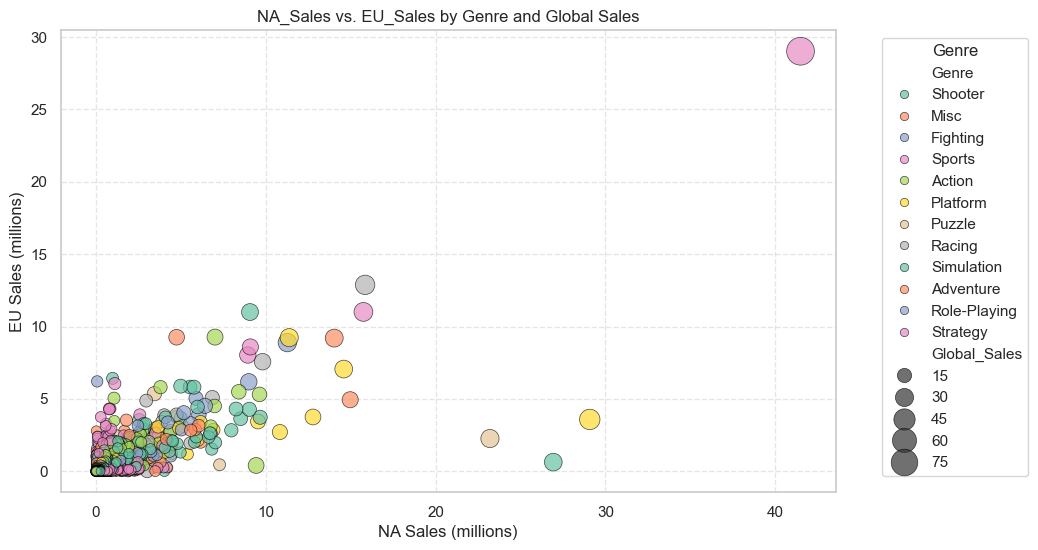

In [47]:
# 8. Create a scatter plot of NA_Sales vs. EU_Sales. What pattern, if any, can you observe?
# Use a scatter plot to identify relationships or trends.

# original code
# sns.scatterplot(data=df, x='NA_Sales', y='EU_Sales', hue='Genre', palette="deep")
# plt.title("NA_Sales vs. EU_Sales")
# plt.legend()
# plt.show()

# Refactor
plt.figure(figsize=(10, 6))

# Adjust size, transparency, and edge color for clarity
sns.scatterplot(
    data=df,
    x="NA_Sales",
    y="EU_Sales",
    hue="Genre",
    palette="Set2",  # Softer colors
    size="Global_Sales",  # Scale points by global impact
    sizes=(40, 400),  # Minimum and maximum size of points
    alpha=0.7,  # Slight transparency
    edgecolor="black",  # Outline for visibility
)

# Customize the legend and title
plt.title("NA_Sales vs. EU_Sales by Genre and Global Sales")
plt.xlabel("NA Sales (millions)")
plt.ylabel("EU Sales (millions)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Genre")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# Based on this graph these are the conclusion I can draw
# 1. Sport games have high sales in both markets
# 2. NA has sells more than 20 millions which EU does not
# 3. For both markets the bulk of sales are in the 0 to 10 mills
# 4. The most sold genres are Sports, Racing, Platform and Simulation

In [48]:
# 9. Find the platform with the highest total sales globally. Which game contributed the most to these sales?
# Group by `Platform`, aggregate `Global_Sales`, and identify the top game contributing to the platform’s success.

sorted_global_sales = df.sort_values(by="Global_Sales", ascending=False)
highest_grossing_platform = sorted_global_sales[
    ["Platform", "Global_Sales", "Name"]
].head(1)
platform = highest_grossing_platform["Platform"].iloc[0]
sales = highest_grossing_platform["Global_Sales"].iloc[0]
game = highest_grossing_platform["Name"].iloc[0]

print(
    f"The platform with the highest total sales globally is {platform} "
    f"with {sales:.2f} million units. The game with the highest contribution "
    f"is {game}."
)

# Optimized version
# platform, sales = df.sort_values(by='Global_Sales', ascending=False).iloc[0][['Platform', 'Global_Sales']]

The platform with the highest total sales globally is Wii with 82.74 million units. The game with the highest contribution is Wii Sports.


In [49]:
# 10. Compute the correlation between global sales and regional sales (NA, EU, JP, etc.).
# Use the `corr()` method to analyze correlations.

all_sales = df[
    ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]
]
print(all_sales.corr())

# Strong correlations:

# NA_Sales and Global_Sales (0.941) have a very strong correlation, which suggests that North American sales have a significant impact on overall global sales.
# EU_Sales and Global_Sales (0.903) also have a strong correlation, making European sales another key driver for global sales.
# Weaker correlations:

# JP_Sales has a much lower correlation with Global_Sales (0.613) compared to North America and Europe, indicating that Japanese sales contribute less to overall global sales in comparison.
# Other_Sales has a moderate correlation (0.748) with Global_Sales, suggesting that regions outside of NA, EU, and JP also play a role but to a lesser extent than the main regions.
# Between-region correlations:

# The correlation between NA_Sales and EU_Sales (0.769) is relatively strong, indicating that games that sell well in North America often also perform well in Europe.
# However, JP_Sales is not as strongly correlated with other regions (e.g., 0.451 with NA_Sales and 0.436 with EU_Sales), reflecting the different gaming preferences in the Japanese market.

              NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
NA_Sales      1.000000  0.768923  0.451283     0.634518      0.941269
EU_Sales      0.768923  1.000000  0.436379     0.726256      0.903264
JP_Sales      0.451283  0.436379  1.000000     0.290559      0.612774
Other_Sales   0.634518  0.726256  0.290559     1.000000      0.747964
Global_Sales  0.941269  0.903264  0.612774     0.747964      1.000000


# Level 3: Data Science Applications

In [50]:
# 11. Perform linear regression to predict Global_Sales using NA_Sales and EU_Sales as predictors.
# Train a regression model using `sklearn` or `statsmodels`.

model_11 = LinearRegression()
X11 = df[["NA_Sales", "EU_Sales"]]
y11 = df["Global_Sales"]

X11_train, X11_test, y11_train, y11_test = train_test_split(
    X11, y11, shuffle=True, train_size=0.6
)

model_11.fit(X11_train, y11_train)

predictions11 = model_11.predict(X11_test)
r2_11 = r2_score(y11_test, predictions11)
rmse_11 = root_mean_squared_error(y11_test, predictions11)

print(f"RMSE: {rmse_11:.4f}")
print(f"R² Score: {r2_11:.4f}")

residuals = y11_test - predictions11

# Plot the residuals (difference between predicted and actual values) to
# see if the errors are randomly distributed or if there’s a pattern
# plt.figure(figsize=(8, 6))
# sns.histplot(residuals, kde=True)
# plt.title("Distribution of Residuals")
# plt.xlabel("Prediction Error")
# plt.show()

RMSE: 0.2927
R² Score: 0.9751


              Name  Cluster
0        Asteroids        1
1  Missile Command        1
2          Kaboom!        1
3         Defender        1
4           Boxing        1
5       Ice Hockey        1
6          Freeway        1
7           Bridge        1
8         Checkers        1
9         Pitfall!        1
[[ 2.50136839  2.93753591  2.0256033   2.55411629]
 [-0.10021186 -0.11113021 -0.07955455 -0.09926017]
 [16.133986   14.4483393  11.96943245 14.37087849]]


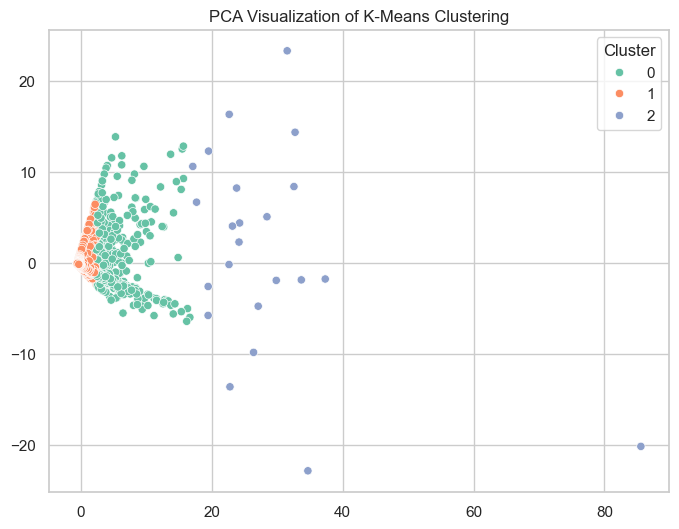

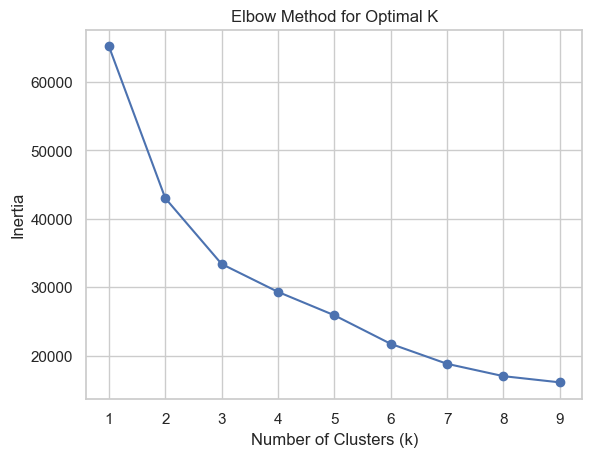

In [51]:
# 12. Perform feature scaling on the sales columns and train a k-means clustering model to group games into clusters based on regional sales.
# Apply scaling and clustering to see patterns in the data.

# Select columns related to regional sales
sales_columns = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]]

# Initialize and apply the scaler
scaler = StandardScaler()
scaled_sales = scaler.fit_transform(sales_columns)

# Choose 3 clusters (this can be optimized later)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_sales)

df["Cluster"] = kmeans.labels_
print(df[["Name", "Cluster"]].head(10))

print(kmeans.cluster_centers_)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_sales)

# PCA Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_features[:, 0],
    y=reduced_features[:, 1],
    hue=df["Cluster"],
    palette="Set2",
    legend="full",
)
plt.title("PCA Visualization of K-Means Clustering")
plt.show()

# Elbow method
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_sales)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [52]:
# 13. Which cluster has the games with the highest sales, and what is the general genre distribution within that cluster?
# Analyze the clusters and their characteristics.

# My Code
# highest_sales_cluster = df.groupby(['Cluster', 'Genre']).agg(
#     cluster_global_sales = ("Global_Sales", "sum"),
#     cluster_genre_distribution = ("Genre", "count")
# )
# highest_sales_cluster.sort_values(by=['Cluster','cluster_global_sales'], ascending=False)

# Optimized answer

highest_sales_cluster = df.groupby("Cluster").agg(
    cluster_global_sales=("Global_Sales", "sum")
)
top_cluster = highest_sales_cluster[
    "cluster_global_sales"
].idxmax()  # Find the cluster with highest sales
print(f"Cluster with the highest sales is: {top_cluster}")

# Filter the original DataFrame for the top cluster
top_cluster_genre_distribution = (
    df[df["Cluster"] == top_cluster]
    .groupby("Genre")
    .agg(
        total_global_sales=("Global_Sales", "sum"),
        game_count=("Genre", "count"),
    )
    .sort_values(by="total_global_sales", ascending=False)
)  # Sort by sales for better readability

print(top_cluster_genre_distribution)

Cluster with the highest sales is: 1
              total_global_sales  game_count
Genre                                       
Action                   1171.78        3147
Sports                    912.98        2242
Shooter                   557.13        1210
Misc                      522.41        1642
Role-Playing              509.28        1405
Racing                    464.08        1188
Platform                  403.95         820
Fighting                  335.44         812
Simulation                282.23         830
Adventure                 192.99        1265
Puzzle                    154.74         559
Strategy                  147.34         664


Text(2006.0, 20.541999999999998, 'Peak: 2006.0, 19.54M')

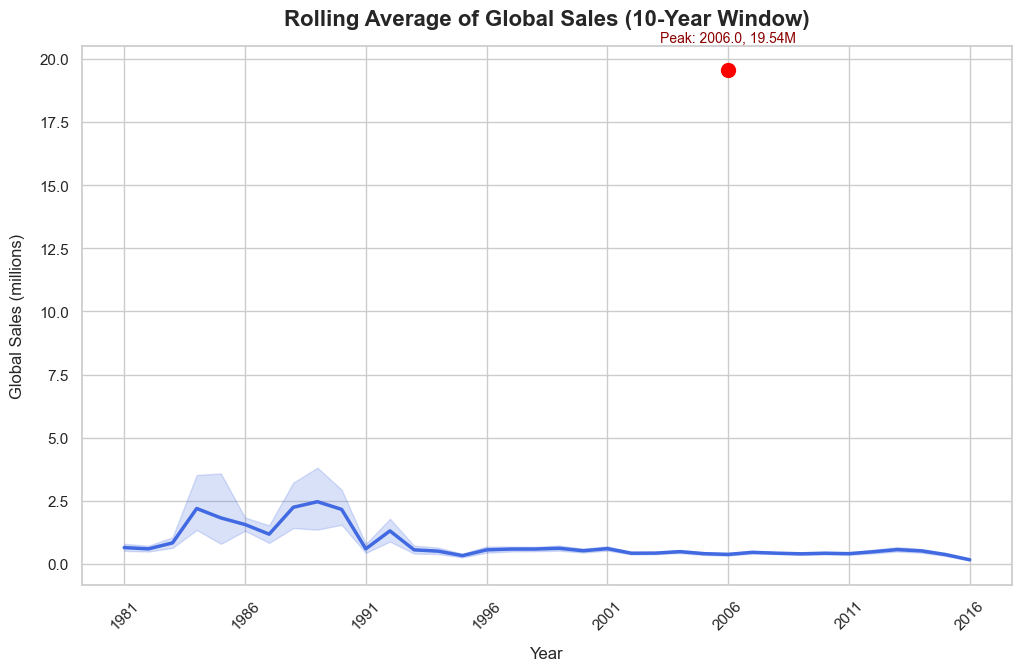

In [53]:
# 14. Compute the rolling average of yearly sales and identify any trends or spikes.
# Use the `rolling()` method to smooth out time series data.

df_14 = (
    df.groupby(df.Year.dt.year)["Global_Sales"]
    .rolling(10)
    .mean()
    .dropna()
    .reset_index()
)


# My Graph
# plt.figure(figsize = (10,6))
# plt.plot(df_14.Year,df_14.Global_Sales,linestyle ='-',
#          color = 'blue',linewidth=2,markersize=5,
#          markerfacecolor='r')
# plt.title("Rolling average of yearly sales",fontsize = 16)
# plt.xlabel("Year",fontsize = 12)
# plt.ylabel("Global AVG Sales",fontsize = 12)
# plt.show()

# Graph optimization

sns.set_theme(style="whitegrid", palette="muted")

# Lineplot with confidence interval and custom formatting
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_14, x="Year", y="Global_Sales", linewidth=2.5, color="royalblue"
)

# Enhancing the plot
plt.title(
    "Rolling Average of Global Sales (10-Year Window)",
    fontsize=16,
    weight="bold",
    pad=15,
)
plt.xlabel("Year", fontsize=12, labelpad=10)
plt.ylabel("Global Sales (millions)", fontsize=12, labelpad=10)

# Formatting the x-axis for readability
plt.xticks(
    ticks=range(df_14["Year"].min(), df_14["Year"].max() + 1, 5), rotation=45
)

# Optional: Highlight specific years (e.g., peak year)
peak_sales_year = df_14.loc[df_14["Global_Sales"].idxmax()]
plt.scatter(
    peak_sales_year["Year"],
    peak_sales_year["Global_Sales"],
    color="red",
    s=100,
)
plt.text(
    peak_sales_year["Year"],
    peak_sales_year["Global_Sales"] + 1,
    f"Peak: {peak_sales_year['Year']}, {peak_sales_year['Global_Sales']:.2f}M",
    fontsize=10,
    ha="center",
    va="bottom",
    color="darkred",
)

# Validation of rolling sales

# x = df.groupby('Year')['Global_Sales'].sum()
# print(x)

# # Calculate raw yearly totals
# raw_totals = df.groupby(df['Year'].dt.year)['Global_Sales'].sum()

# # Find the peak year in raw totals
# peak_year_raw = raw_totals.idxmax()
# peak_sales_raw = raw_totals.max()

# print(f"Raw Totals - Peak Year: {peak_year_raw}, Total Sales: {peak_sales_raw:.2f} million units")

# # Use the rolling average you already computed (df_14)
# rolling_peak_year = df_14.loc[df_14['Global_Sales'].idxmax(), 'Year']
# rolling_peak_value = df_14['Global_Sales'].max()

# print(f"Rolling Average - Peak Year: {rolling_peak_year}, Peak Rolling Avg: {rolling_peak_value:.2f} million units")

# # Compare the results
# if peak_year_raw == rolling_peak_year:
#     print("Validation Success: Both raw totals and rolling average show the same peak year.")
# else:
#     print("Discrepancy Detected: Raw totals and rolling average show different peak years.")

C:\Users\pliqui\AppData\Local\Temp\ipykernel_10836\388019027.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Region", loc="upper right")


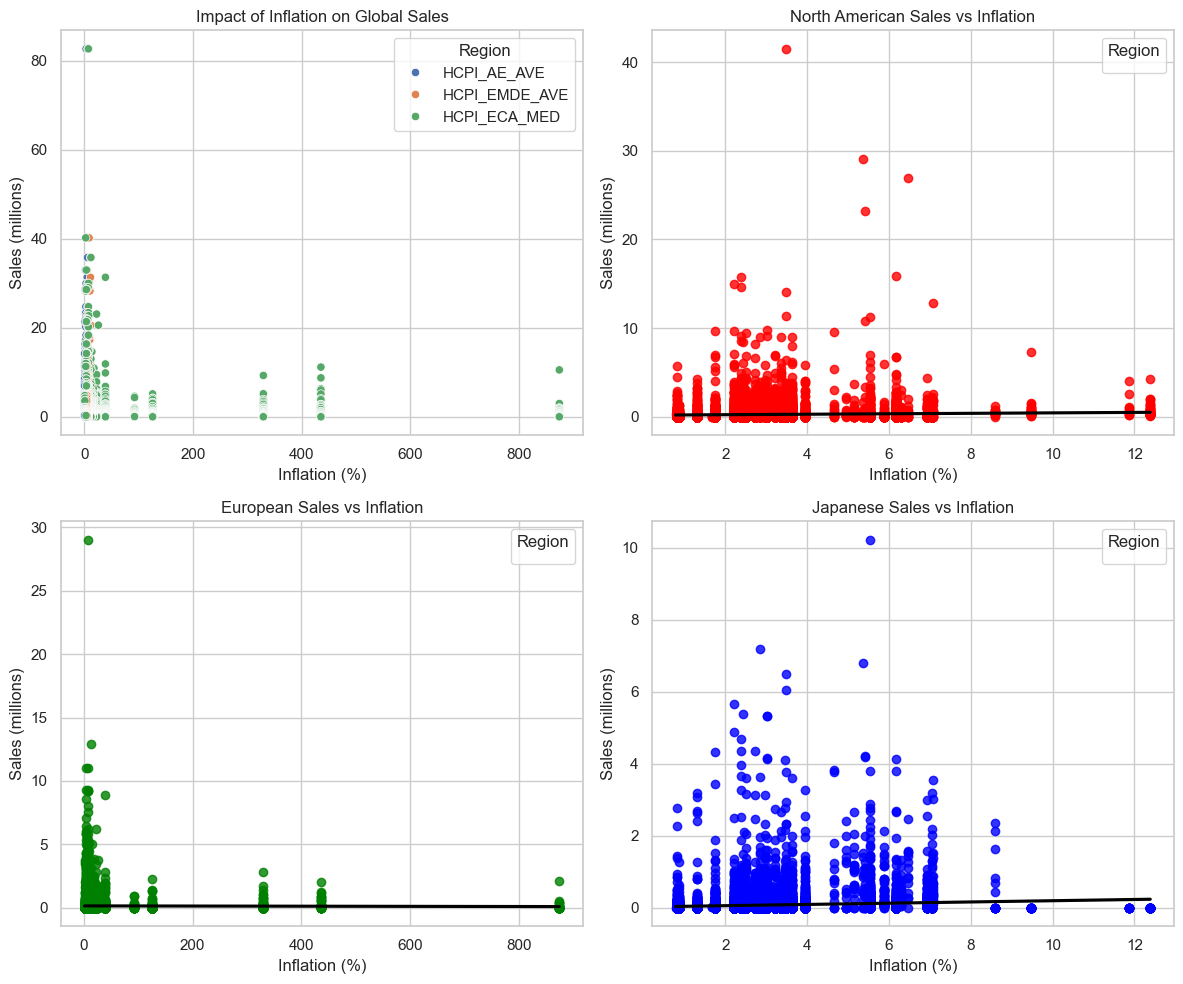

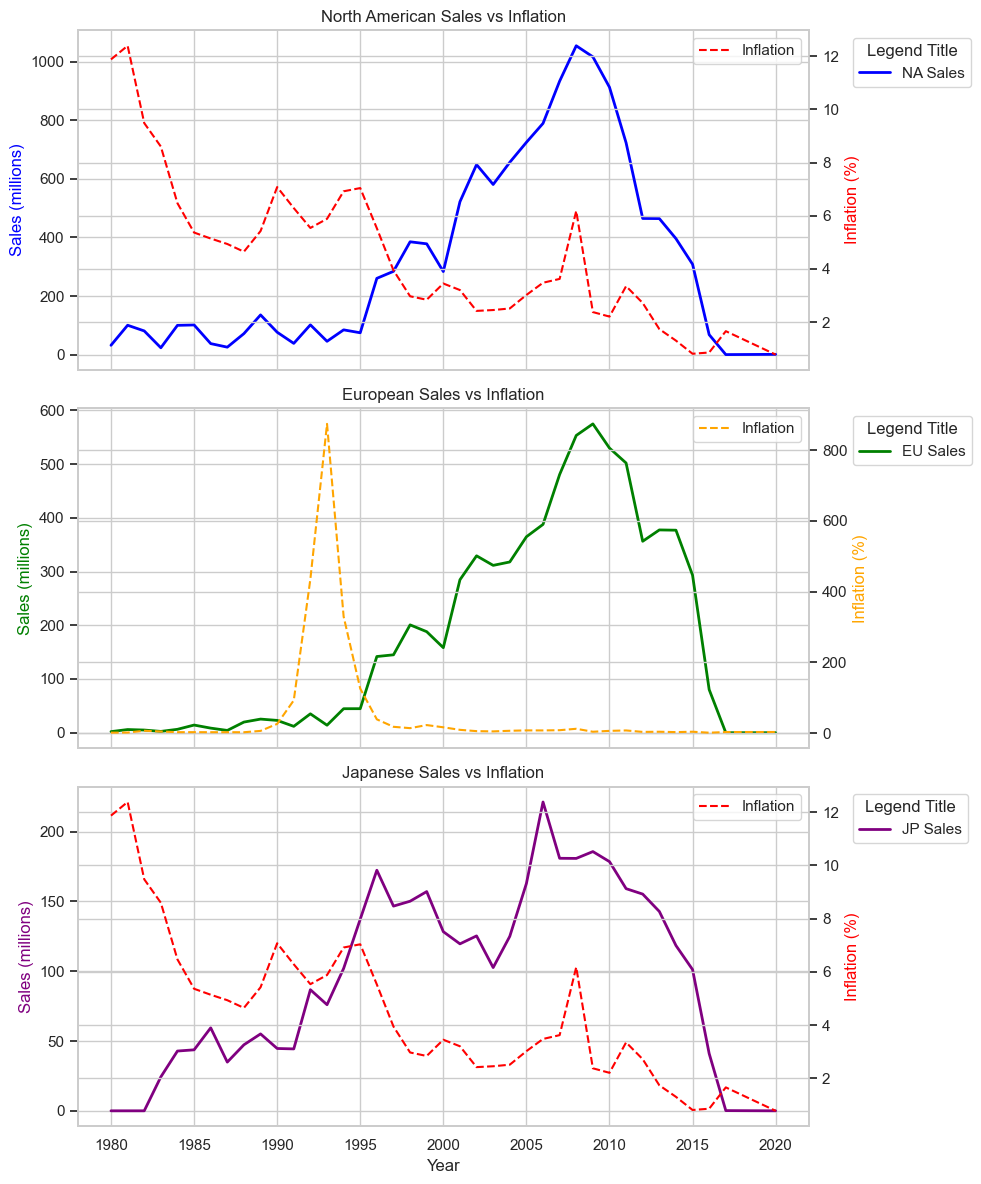

In [54]:
# 15. Use the merge_asof() method to combine the yearly sales data with an external time series dataset (like inflation rates) and analyze any relationships.
# Integrate and interpret data from two time series.

# Load the inflation dataset
inflation_data = pd.read_excel("Inflation-data.xlsx", sheet_name="Aggregate")

# Checking the dataset
inflation_data.head(10)

# Checks for potential data cleaning
# inflation_data.isnull().sum()
# inflation_data.nunique()
# inflation_data.duplicated().sum()

# Copy the dataset for cleaning
df_inflation = inflation_data.copy()
df_inflation.columns
# df_inflation.info()
df_inflation.head()

# Ensure all column names are treated as strings
df_inflation.columns = df_inflation.columns.astype(str)

df_inflation = df_inflation.loc[
    (df_inflation["Series Name"] == "HCPI_AE_AVE")
    | (df_inflation["Series Name"] == "HCPI_EMDE_AVE")
    | (df_inflation["Series Name"] == "HCPI_ECA_MED")
]

# drop columns not needed
df_inflation = df_inflation.drop(
    columns=[
        col
        for col in df_inflation.columns
        if col.isdigit() and (int(col) < 1980 or int(col) > 2020)
    ]
)
df_inflation = df_inflation.drop(
    columns=[
        "Inflation measures",
        "Description",
        "Aggregation",
        "Sample country",
    ]
)
df_inflation = df_inflation.dropna()


# Melt the DataFrame
df_inflation = pd.melt(
    df_inflation,
    id_vars=["Series Name"],  # Keep Series Name as a column
    var_name="Year",  # The column name for years
    value_name="Inflation",  # The column name for inflation rates
)

# Convert Year to datetime for merging
df_inflation["Year"] = pd.to_datetime(df_inflation["Year"], format="%Y")
df_inflation.rename(columns={"Series Name": "Region"}, inplace=True)

# Preview the reshaped DataFrame
df_inflation.head()

# merge the dataframes

merged_df = df.merge(df_inflation, on="Year")
merged_df.head()

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
region_colors = {
    "Global_Sales": "purple",
    "NA_Sales": "red",
    "EU_Sales": "green",
    "JP_Sales": "blue",
}

# Plot 1: Global Sales
sns.scatterplot(
    data=merged_df,
    x="Inflation",
    y="Global_Sales",
    hue="Region",
    palette="deep",
    ax=axes[0, 0],
)
axes[0, 0].set_title("Impact of Inflation on Global Sales")

# Plot 2: NA Sales with trend line
na_filtered = merged_df.loc[merged_df["Region"] == "HCPI_AE_AVE"]
na_filtered = na_filtered.loc[na_filtered["Region"] == "HCPI_AE_AVE"]
sns.regplot(
    data=na_filtered,
    x="Inflation",
    y="NA_Sales",
    scatter_kws={"color": region_colors["NA_Sales"]},
    line_kws={"color": "black"},
    ax=axes[0, 1],
)
axes[0, 1].set_title("North American Sales vs Inflation")

# Plot 3: EU Sales with trend line
eu_filtered = merged_df.loc[merged_df["Region"] == "HCPI_ECA_MED"]
eu_filtered = eu_filtered.loc[eu_filtered["Region"] == "HCPI_ECA_MED"]
sns.regplot(
    data=eu_filtered,
    x="Inflation",
    y="EU_Sales",
    scatter_kws={"color": region_colors["EU_Sales"]},
    line_kws={"color": "black"},
    ax=axes[1, 0],
)
axes[1, 0].set_title("European Sales vs Inflation")

# Plot 4: JP Sales with trend line
jp_filtered = merged_df.loc[merged_df["Region"] == "HCPI_AE_AVE"]
jp_filtered = jp_filtered.loc[jp_filtered["Region"] == "HCPI_AE_AVE"]
sns.regplot(
    data=jp_filtered,
    x="Inflation",
    y="JP_Sales",
    scatter_kws={"color": region_colors["JP_Sales"]},
    line_kws={"color": "black"},
    ax=axes[1, 1],
)
axes[1, 1].set_title("Japanese Sales vs Inflation")

# Adjust layout and legends
for ax in axes.flat:
    ax.legend(title="Region", loc="upper right")
    ax.set_xlabel("Inflation (%)")
    ax.set_ylabel("Sales (millions)")

plt.tight_layout()
plt.show()

# Line Plots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Aggregate sales by year
yearly_sales = (
    merged_df.groupby("Year")[["NA_Sales", "EU_Sales", "JP_Sales"]]
    .sum()
    .reset_index()
)

# North America Plot
sns.lineplot(
    data=yearly_sales,
    x="Year",
    y="NA_Sales",
    ax=axes[0],
    color="blue",
    linewidth=2,
    label="NA Sales",
)
axes[0].set_ylabel("Sales (millions)", color="blue")
axes[0].set_title("North American Sales vs Inflation")
axes[0].legend(
    title="Legend Title", loc="upper left", bbox_to_anchor=(1.05, 1)
)

# Overlay inflation
ax2 = axes[0].twinx()
na_inflation = (
    merged_df[merged_df["Region"] == "HCPI_AE_AVE"]
    .groupby("Year")["Inflation"]
    .mean()
    .reset_index()
)
sns.lineplot(
    data=na_inflation,
    x="Year",
    y="Inflation",
    ax=ax2,
    color="red",
    linestyle="--",
    label="Inflation",
)
ax2.set_ylabel("Inflation (%)", color="red")

# European Plot
sns.lineplot(
    data=yearly_sales,
    x="Year",
    y="EU_Sales",
    ax=axes[1],
    color="green",
    linewidth=2,
    label="EU Sales",
)
axes[1].set_ylabel("Sales (millions)", color="green")
axes[1].set_title("European Sales vs Inflation")
axes[1].legend(
    title="Legend Title", loc="upper left", bbox_to_anchor=(1.05, 1)
)

ax3 = axes[1].twinx()
eu_inflation = (
    merged_df[merged_df["Region"] == "HCPI_ECA_MED"]
    .groupby("Year")["Inflation"]
    .mean()
    .reset_index()
)
sns.lineplot(
    data=eu_inflation,
    x="Year",
    y="Inflation",
    ax=ax3,
    color="orange",
    linestyle="--",
    label="Inflation",
)
ax3.set_ylabel("Inflation (%)", color="orange")

# Japan Plot
sns.lineplot(
    data=yearly_sales,
    x="Year",
    y="JP_Sales",
    ax=axes[2],
    color="purple",
    linewidth=2,
    label="JP Sales",
)
axes[2].set_ylabel("Sales (millions)", color="purple")
axes[2].set_title("Japanese Sales vs Inflation")
axes[2].legend(
    title="Legend Title", loc="upper left", bbox_to_anchor=(1.05, 1)
)

ax4 = axes[2].twinx()
jp_inflation = (
    merged_df[merged_df["Region"] == "HCPI_AE_AVE"]
    .groupby("Year")["Inflation"]
    .mean()
    .reset_index()
)
sns.lineplot(
    data=jp_inflation,
    x="Year",
    y="Inflation",
    ax=ax4,
    color="red",
    linestyle="--",
    label="Inflation",
)
ax4.set_ylabel("Inflation (%)", color="red")

plt.tight_layout()
plt.show()


# # Plot 1: Global Sales
# sns.scatterplot(data=merged_df, x='Inflation', y='Global_Sales', hue='Region', ax=axes[0, 0], palette='deep')
# axes[0, 0].set_title("Global Sales vs Inflation")

# # Plot 2: NA Sales
# na_filtered = merged_df.loc[merged_df['Region'] == 'HCPI_AE_AVE'].copy()
# na_filtered = na_filtered.loc[na_filtered['Region'] == 'HCPI_AE_AVE']

# sns.scatterplot(data=na_filtered, x='Inflation', y='NA_Sales', hue='Region', ax=axes[0, 1], palette='deep')
# axes[0, 1].set_title("NA Sales vs Inflation")

# # Plot 3: EU Sales
# eu_filtered = merged_df.loc[merged_df['Region'] == 'HCPI_ECA_MED'].copy()
# eu_filtered = eu_filtered.loc[eu_filtered['Region'] == 'HCPI_ECA_MED']
# sns.scatterplot(data=eu_filtered, x='Inflation', y='EU_Sales', hue='Region', ax=axes[1, 0], palette='deep')
# axes[1, 0].set_title("EU Sales vs Inflation")

# # Plot 4: JP Sales
# jp_filtered = merged_df.loc[merged_df['Region'] == 'HCPI_AE_AVE'].copy()
# jp_filtered = jp_filtered.loc[jp_filtered['Region'] == 'HCPI_AE_AVE']
# sns.scatterplot(data=jp_filtered, x='Inflation', y='JP_Sales', hue='Region', ax=axes[1, 1], palette='deep')
# axes[1, 1].set_title("JP Sales vs Inflation")

# # Adjust layout
# plt.tight_layout()
# plt.show()


# x_15 = merged_df.groupby('Year')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales', 'Inflation']].sum()

# plt.figure(plt.figure(figsize = (10,6)))
# plt.plot(x_15.index, x_15.values, marker='o',
#          linestyle ='-',color = 'blue',linewidth=2,
#          markersize=5,markerfacecolor='r')

# Level 4: Advanced Analytics & Visualization

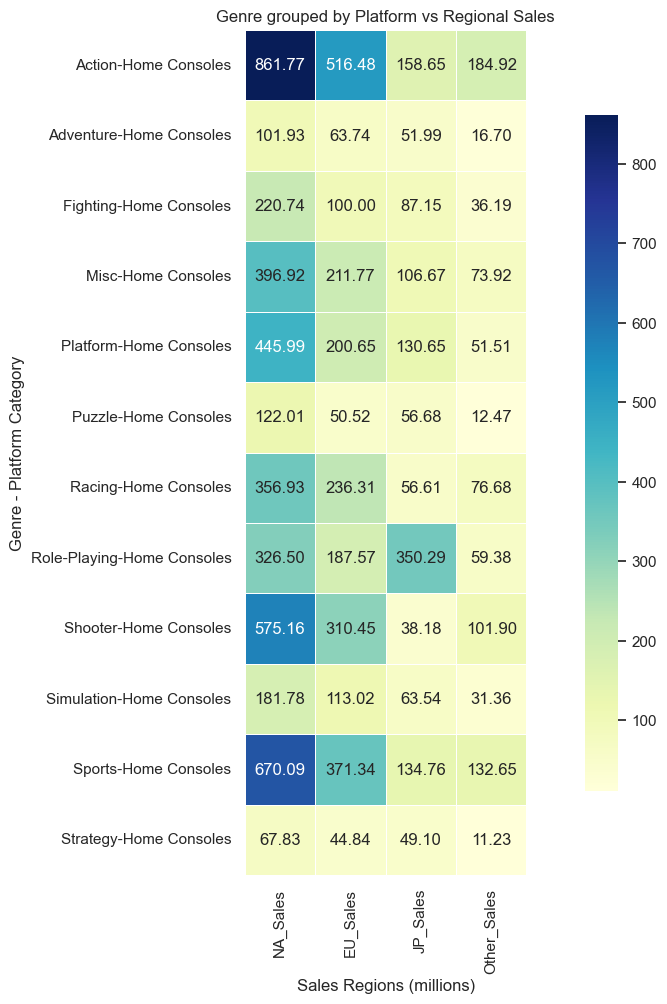

In [55]:
# 16. Generate a heatmap showing the correlation between platforms, genres, and regional sales.
# Visualize the correlations to uncover hidden patterns.

# Categorize the consoles so the heatmap does not get overcrowded with information
home_consoles = [
    "2600",
    "NES",
    "SNES",
    "GEN",
    "N64",
    "DC",
    "PS",
    "PS2",
    "PS3",
    "PS4",
    "XB",
    "X360",
    "XOne",
    "Wii",
    "WiiU",
    "GC",
    "SCD",
    "SAT",
    "NG",
    "3DO",
]
handheld_consoles = [
    "GB",
    "GBA",
    "DS",
    "3DS",
    "PSP",
    "PSV",
    "WS",
    "GG",
    "TG16",
    "PCFX",
]
pc = ["PC"]
other = ["SCD", "3DO", "GG", "NG", "PCFX"]

for plat in df.Platform.unique():
    if plat in home_consoles:
        df["Platform Category"] = "Home Consoles"
    elif plat in handheld_consoles:
        df["Platform Category"] = "Handheld Consoles"
    elif plat in pc:
        df["Platform Category"] = "PC"
    else:
        df["Platform Category"] = "Others"

# dataset for this assignment
df_16 = df

# Group by
df_16 = df.groupby(["Genre", "Platform Category"])[
    ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
].sum()
df_16.head()


sns.set_theme(style="whitegrid", font_scale=1)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    df_16,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8},
    xticklabels=True,
    yticklabels=True,
)
plt.xlabel("Sales Regions (millions)")
plt.ylabel("Genre - Platform Category")


# Improve layout and display
plt.tight_layout()
plt.title("Genre grouped by Platform vs Regional Sales")
plt.show()

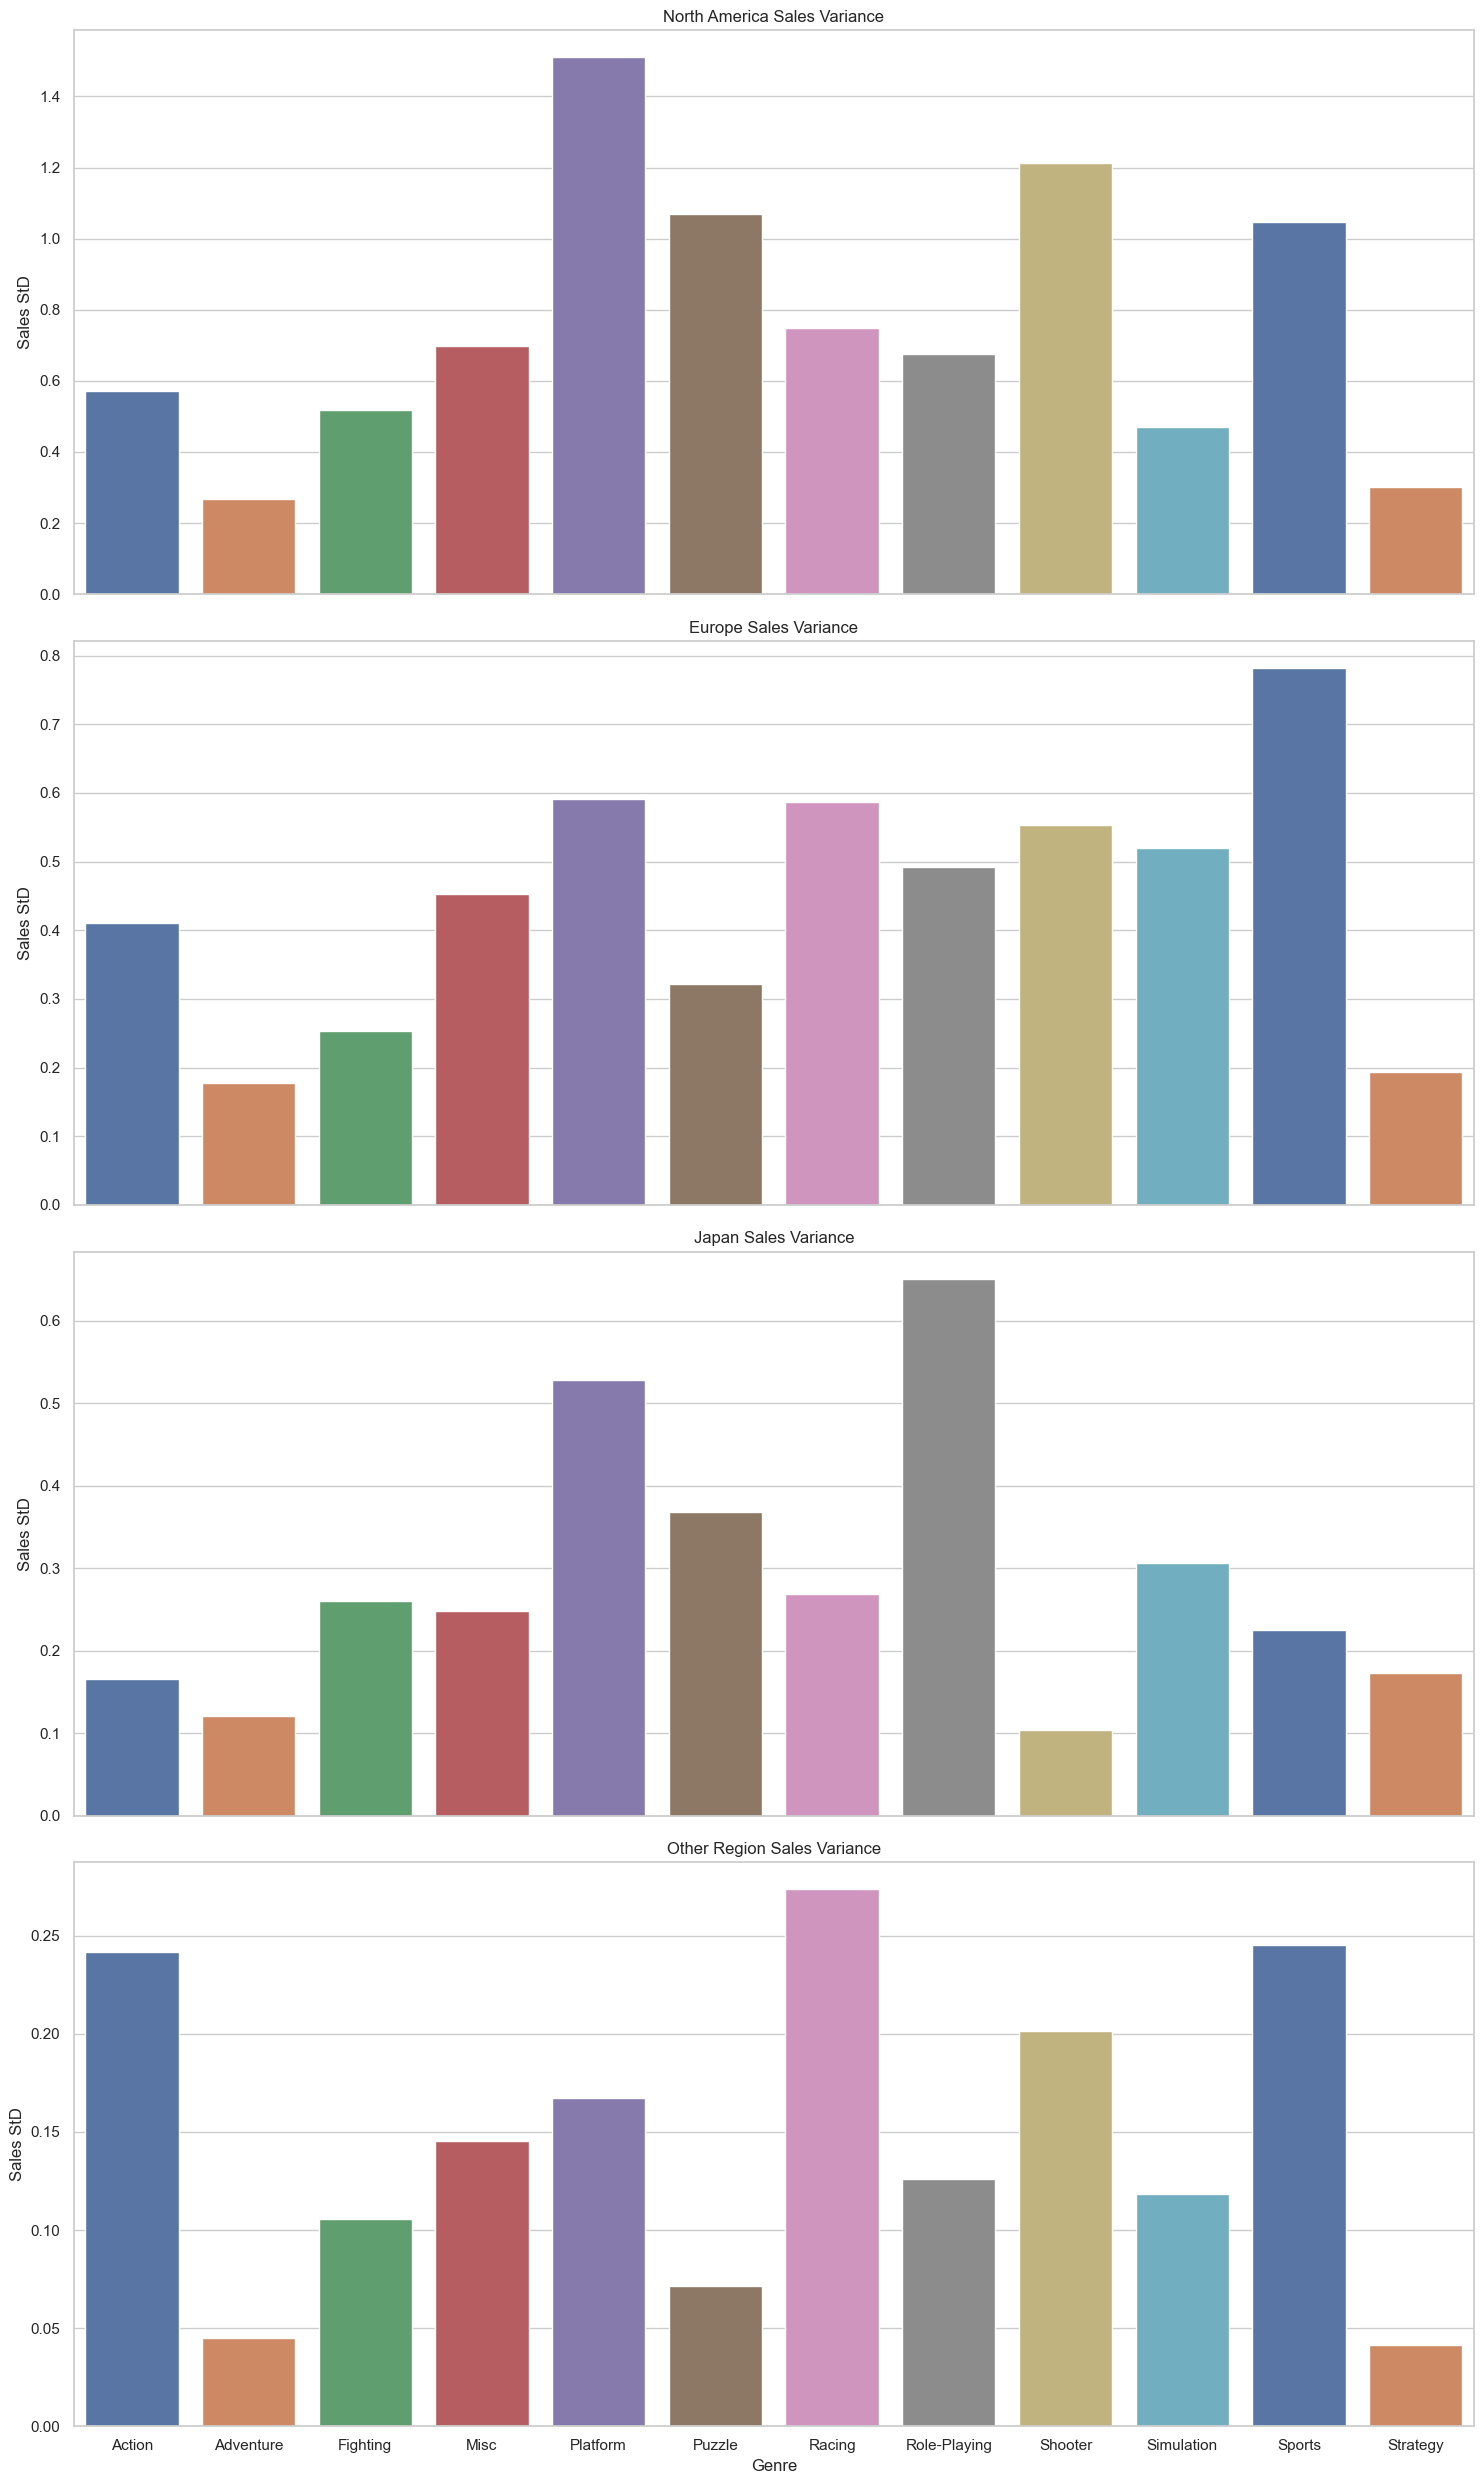

In [56]:
# 17. Identify genres with the highest variance in sales across regions using standard deviation.
# Find which genres have the most sales variability.

genre_high_variance = (
    df.groupby(["Genre"])[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]]
    .std()
    .reset_index()
)
genre_high_variance.head()


# Create the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 25), sharex=True)

# North America Sales Plot
sns.barplot(
    data=genre_high_variance,
    x="Genre",
    y="NA_Sales",
    palette="deep",
    hue="Genre",
    ax=axes[0],
)
axes[0].set_title("North America Sales Variance")

# EU Sales Plot
sns.barplot(
    data=genre_high_variance,
    x="Genre",
    y="EU_Sales",
    palette="deep",
    hue="Genre",
    ax=axes[1],
)
axes[1].set_title("Europe Sales Variance")

# Japan Sales Plot
sns.barplot(
    data=genre_high_variance,
    x="Genre",
    y="JP_Sales",
    palette="deep",
    hue="Genre",
    ax=axes[2],
)
axes[2].set_title("Japan Sales Variance")

# Other Sales Plot
sns.barplot(
    data=genre_high_variance,
    x="Genre",
    y="Other_Sales",
    palette="deep",
    hue="Genre",
    ax=axes[3],
)
axes[3].set_title("Other Region Sales Variance")

# Adjust layout and legends
for ax in axes.flat:
    ax.set_xlabel("Genre")
    ax.set_ylabel("Sales StD")
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

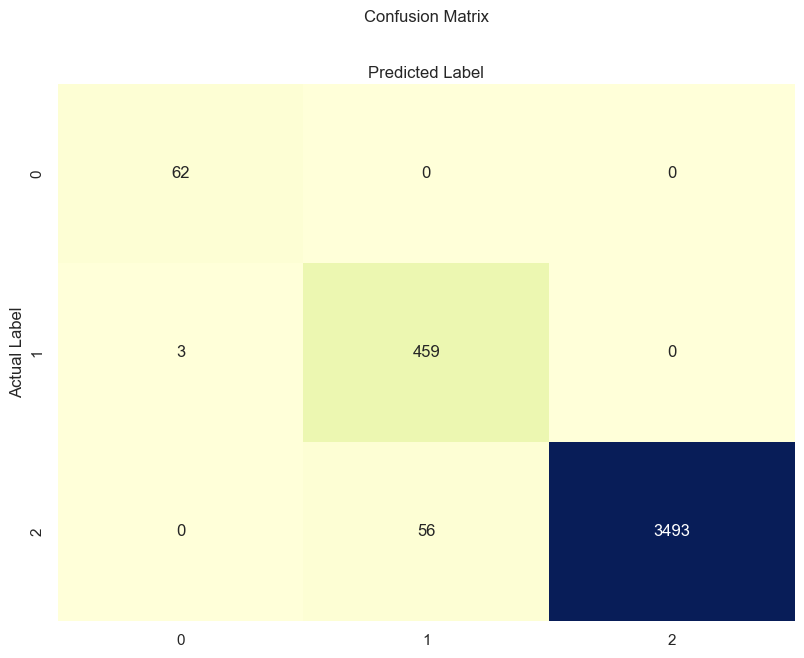

               precision    recall  f1-score   support

   High sales       0.95      1.00      0.98        62
 Medium sales       0.89      0.99      0.94       462
    Low sales       1.00      0.98      0.99      3549

     accuracy                           0.99      4073
    macro avg       0.95      0.99      0.97      4073
 weighted avg       0.99      0.99      0.99      4073

RMSE: 0.0053
R² Score: 1.0000


In [57]:
# 18. Train both a classification model and a regression model to predict global sales.
# Compare the performance of each and discuss when each model would be appropriate.

# Define the function to classify sales


def classify_sales(sales: float) -> int:
    """
    Classify sales into categories based on global sales figures.

    Categories:
        - 0: High sales (>= 5 million)
        - 1: Medium sales (1 million to < 5 million)
        - 2: Low sales (< 1 million)

    Args:
        sales (float): The global sales value in millions.

    Returns:
        int: The category of the sales (0 = High, 1 = Medium, 2 = Low).
    """
    if sales >= 5:
        return 0  # High sales
    elif 1 <= sales < 5:
        return 1  # Medium sales
    else:
        return 2  # Low sales


# Ensure 'Global_Sales' exists
if "Global_Sales" in df.columns:
    df["Sales_Category"] = df["Global_Sales"].apply(classify_sales)
else:
    raise ValueError("Column 'Global_Sales' not found in DataFrame")

df["High_Sales"] = (df["Global_Sales"] > 5).astype(
    int
)  # Binary classification

# Features (Regional Sales)
# feature_cols_18 = ['NA_Sales_Ratio', 'EU_Sales_Ratio', 'JP_Sales_Ratio', 'Other_Sales_Ratio']
feature_cols_18 = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
X18 = df[feature_cols_18]
y18 = df["Sales_Category"]

# Split the dataset
X18_train, X18_test, y18_train, y18_test = train_test_split(
    X18, y18, test_size=0.25, random_state=16
)

smote = imblearn.over_sampling.SMOTE(sampling_strategy="auto", random_state=16)
X_balanced, y_balanced = smote.fit_resample(X18_train, y18_train)

# Instantiate and train the model
logreg_18 = LogisticRegression()
logreg_18.fit(X_balanced, y_balanced)

# Predictions
y18_pred = logreg_18.predict(X18_test)

# Confusion matrix
cnf_matrix_18 = confusion_matrix(y18_test, y18_pred)

# Heatmap visualization
class_names = [0, 1, 2]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(cnf_matrix_18), annot=True, cmap="YlGnBu", fmt="g", cbar=False
)

# Formatting
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")

plt.show()

target_names_18 = ["High sales", " Medium sales", "Low sales"]
print(classification_report(y18_test, y18_pred, target_names=target_names_18))

# Linear regression

# Create a temporary copy to avoid modifying df
df_temp = df.copy()
df_temp["Year"] = df_temp["Year"].dt.year.astype(int)

# Features for Linear Regression
lr_features = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Year",
    "Sales_Category",
]
x18_lr = df_temp[lr_features]
y18_lr = df_temp["Global_Sales"]

# Split the dataset
X18_train, X18_test, y18_train, y18_test = train_test_split(
    x18_lr, y18_lr, test_size=0.25, random_state=16
)

# Standardize the features
scaler_18 = StandardScaler()
X18_train_scaled = scaler_18.fit_transform(X18_train)
X18_test_scaled = scaler_18.transform(X18_test)

# Train Linear Regression model
model_18 = LinearRegression()
model_18.fit(X18_train_scaled, y18_train)

# Predictions
predictions18 = model_18.predict(X18_test_scaled)
r2_18 = r2_score(y18_test, predictions18)
rmse_18 = root_mean_squared_error(y18_test, predictions18)

# Results
print(f"RMSE: {rmse_18:.4f}")
print(f"R² Score: {r2_18:.4f}")

# Residuals
residuals = y18_test - predictions18

RFC Accuracy: 0.9955806530812669


C:\Users\pliqui\AppData\Local\Temp\ipykernel_10836\3681811431.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


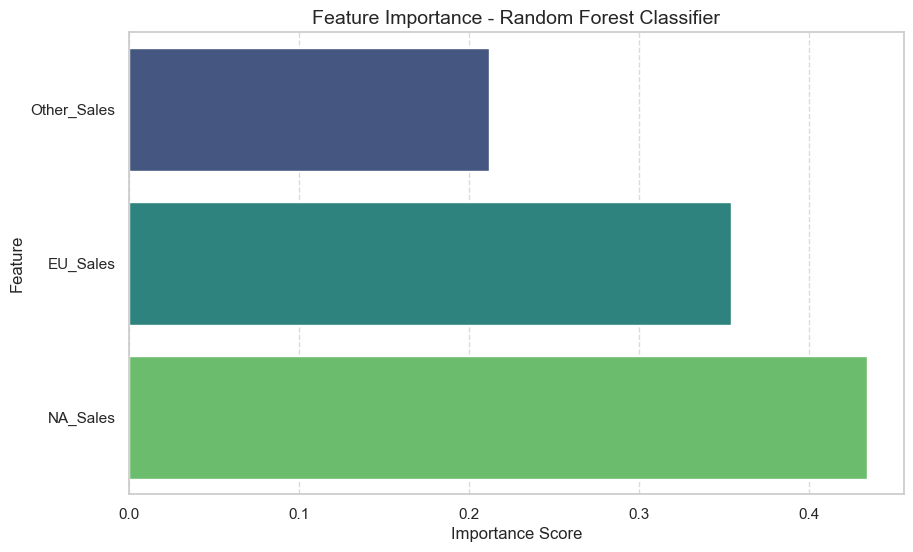

In [ ]:
# 19. Build a predictive model to classify whether a game will have high or low global sales based on its regional sales.
# Train a classification model using `scikit-learn` or `statsmodels`.

feature_cols_19 = ["NA_Sales", "EU_Sales", "Other_Sales"]
X19 = df[feature_cols_19]
y19 = df["High_Sales"]

# Split the dataset
X19_train, X19_test, y19_train, y19_test = train_test_split(
    X19, y19, test_size=0.25, random_state=16
)

# Create the model and fit
rf_classifier_19 = RandomForestClassifier(
    n_estimators=300, max_depth=20, random_state=16
)
rf_classifier_19.fit(X19_train, y19_train)

# Predictions
y19_rfc_pred = rf_classifier_19.predict(X19_test)
rfc_accuracy_19 = accuracy_score(y19_test, y19_rfc_pred)

print(f"RFC Accuracy: {rfc_accuracy_19}")
rf_classifier_19.feature_importances_

# Extract feature importance values
feature_importance_values = rf_classifier_19.feature_importances_
feature_names = (
    feature_cols_19  # ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
)

# Create a DataFrame for plotting
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importance_values}
)
importance_df = importance_df.sort_values(
    by="Importance", ascending=True
)  # Sort for better visualization

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")

# Enhance the plot
plt.title("Feature Importance - Random Forest Classifier", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

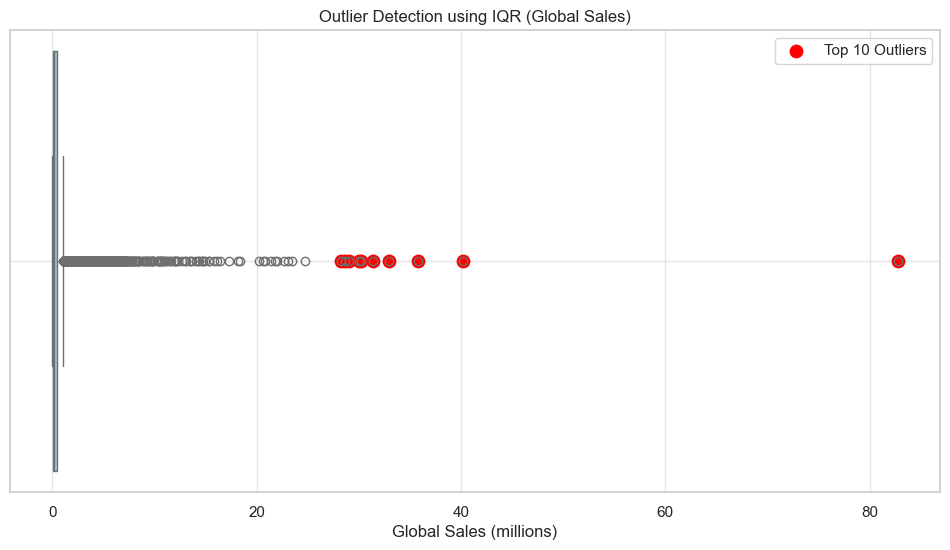

In [73]:
# 20. Analyze outliers in the dataset using the IQR (interquartile range) method and visualize the top 10 outliers.
# Detect and visualize outliers in the dataset.

# Compute IQR
Q1 = df["Global_Sales"].quantile(0.25)
Q3 = df["Global_Sales"].quantile(0.75)
IQR = Q3 - Q1

# Define Outlier Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df[df["Global_Sales"] > upper_bound].copy()

# Sort Top 10 Outliers
top_10_outliers = outliers.sort_values(
    by="Global_Sales", ascending=False
).head(10)

# Boxplot for Visualizing Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Global_Sales", color="skyblue", showfliers=True)
plt.scatter(
    top_10_outliers["Global_Sales"],
    [0] * len(top_10_outliers),
    color="red",
    s=80,
    label="Top 10 Outliers",
)
plt.xlabel("Global Sales (millions)")
plt.title("Outlier Detection using IQR (Global Sales)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()